In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
import matplotlib.pyplot as plt
import torchvision

import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
# Read in a image from torchvision

--2024-03-06 09:22:07--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 3.162.125.110, 3.162.125.35, 3.162.125.66, ...
Connecting to segment-anything.com (segment-anything.com)|3.162.125.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.01s   

2024-03-06 09:22:08 (20.1 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# def factorize(A, k, device=torch.device("cpu"),epsilon=0.01):
#     """Factorize the matrix D into A and B"""
#     A = A.to(device)
#     # Randomly initialize A and B
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)
#     mask = ~torch.isnan(A)
#     # Train the model
#     for i in range(1000):
#         # Compute the loss
#         diff_matrix = torch.mm(W, H) - A
#         diff_vector = diff_matrix[mask]
#         loss = torch.norm(diff_vector)
#         # Zero the gradients
#         optimizer.zero_grad()

#         # Backpropagate
#         loss.backward()

#         # Update the parameters
#         optimizer.step()

#     return W, H, loss

In [4]:
import torch
from torch.autograd import Variable

def factorize(A,k,device=torch.device("cpu"),epsilon=0.01):
  A = A.to(device)
# Set the seed for reproducibility
  torch.manual_seed(42)

# Define the matrix A that you want to factorize

# Define the sizes of matrices B and C
  n, m = A.size()
  # k = 10  # Set the desired rank of factorization

  # Initialize matrices B and C randomly
  W = torch.randn(n, k, requires_grad=True,device = device)
  H = torch.randn(k, m, requires_grad=True,device = device)

  # Set the learning rate and convergence criteria
  learning_rate = 0.001
  max_iterations = 10000
  prev_loss=np.inf
  # Perform gradient descent optimization
  for iteration in range(max_iterations):
      # Calculate the current approximation A_hat = BC
      A_hat = torch.matmul(W, H)
      mask = ~torch.isnan(A)

      # Calculate the reconstruction error
      diff_matrix = A_hat - A
      diff_vector = diff_matrix[mask]
      loss = torch.norm(diff_vector)
      if (iteration%500==0):
        print(loss)
      # Check for convergence
      if abs(loss-prev_loss) < epsilon:
          print(f"Converged after {iteration + 1} iterations.")
          break
      prev_loss=loss
      # Compute gradients
      loss.backward()

      # Update matrices B and C using gradient descent
      with torch.no_grad():
          W -= learning_rate * W.grad
          H -= learning_rate * H.grad

          # Manually zero the gradients after updating
          W.grad.zero_()
          H.grad.zero_()

  return W,H,loss

# import numpy as np
# def factorize_color(img_tensor,rank,device,epsilon = 0.01):
#   WR, HR, lossR = GD_Factorize(img_tensor[0,:,:], rank, device=device)
#   WG, HG, lossG = GD_Factorize(img_tensor[1,:,:], rank, device=device)
#   WB, HB, lossB = GD_Factorize(img_tensor[2,:,:], rank, device=device)

#   return (WR,HR,WG,HG,WB,HB), lossR+lossG+lossB

In [5]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [6]:
img = torch.tensor(img, dtype=torch.float)
# img = img.mean(dim=0, keepdim=False)


<ipython-input-6-4f1b7f148bb1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


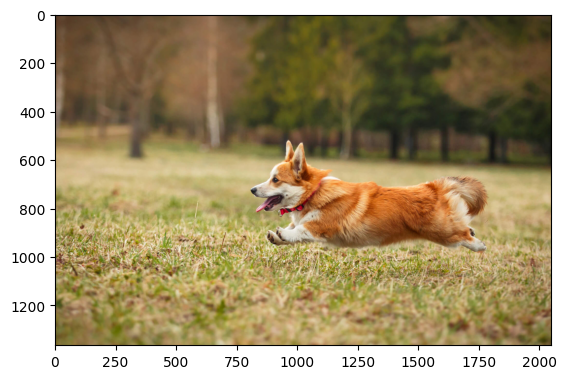

In [7]:
plt.imshow(img.permute(1,2,0)/255)

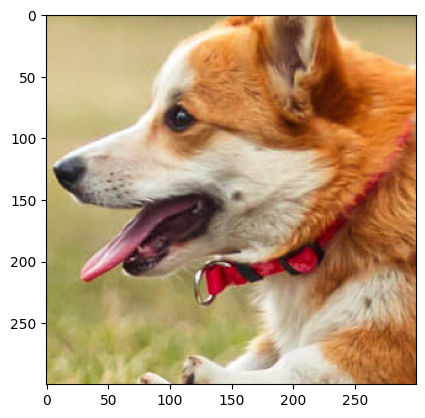

In [8]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
plt.imshow(crop.permute(1,2,0)/255)

In [9]:

def extract_patch(image_tensor, patch_location, patch_size):
    """Extract a rectangular patch from the image tensor."""
    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Extract the patch into a different variable
    extracted_patch = image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size].clone()

    return extracted_patch


def make_patch_nan(image_tensor, patch_location, patch_size):
    """Make a rectangular patch of an image as NaN values."""
    # Copy the image tensor to avoid modifying the original
    image_tensor = image_tensor.clone()

    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Set the patch region to NaN values
    image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size] = float('nan')

    return image_tensor


In [10]:
patch_size= 50
imgs = []
patches = []
patch_locsx = [10, 60, 185]
patch_locsy = [10, 30, 80]

In [11]:
# Make the patch region NaN values

for i in range(3):
  imgs.append(make_patch_nan(crop, (patch_locsx[i], patch_locsy[i]), patch_size))
  patches.append(extract_patch(crop,(patch_locsx[i], patch_locsy[i]), patch_size))


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


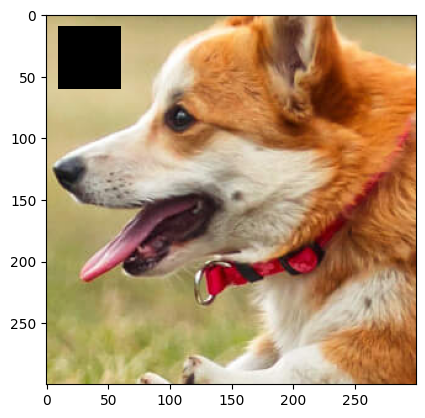

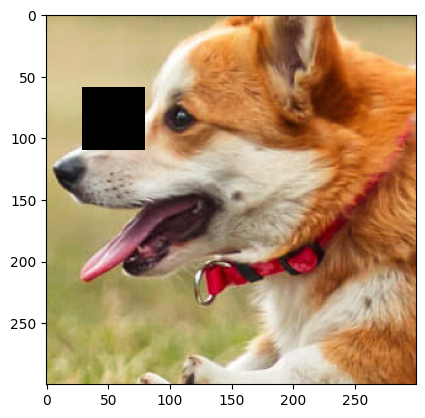

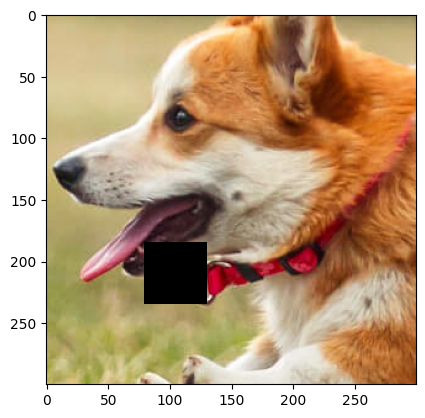

In [12]:
for img in imgs:
  plt.imshow(img.permute(1, 2, 0)/255)
  plt.show()

In [13]:
import numpy as np
def col_fact(img_tensor,device,rank):
  WR, HR, lossR = factorize(img_tensor[0,:,:], rank, device=device)
  WG, HG, lossG = factorize(img_tensor[1,:,:], rank, device=device)
  WB, HB, lossB = factorize(img_tensor[2,:,:], rank, device=device)
  pred_imgR=torch.mm(WR, HR).cpu().detach()
  pred_imgG=torch.mm(WG, HG).cpu().detach()
  pred_imgB=torch.mm(WB, HB).cpu().detach()
  image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
  image = torch.tensor(image)
  return image


In [14]:
r = [5, 10, 25, 50]

In [15]:
pred_patchs = []
for patch in patches:
  for rank in r:
    pred_patch=col_fact(patch,device,rank)
    pred_patchs.append(pred_patch)

tensor(10717.2148, grad_fn=<LinalgVectorNormBackward0>)
tensor(10705.0596, grad_fn=<LinalgVectorNormBackward0>)
tensor(10676.6953, grad_fn=<LinalgVectorNormBackward0>)
tensor(10601.7148, grad_fn=<LinalgVectorNormBackward0>)
tensor(10399.7744, grad_fn=<LinalgVectorNormBackward0>)
tensor(9854.6211, grad_fn=<LinalgVectorNormBackward0>)
tensor(8383.6299, grad_fn=<LinalgVectorNormBackward0>)
tensor(4429.8291, grad_fn=<LinalgVectorNormBackward0>)
tensor(105.7429, grad_fn=<LinalgVectorNormBackward0>)
tensor(92.7174, grad_fn=<LinalgVectorNormBackward0>)
tensor(85.6965, grad_fn=<LinalgVectorNormBackward0>)
Converged after 5086 iterations.
tensor(9754.5312, grad_fn=<LinalgVectorNormBackward0>)
tensor(9742.3818, grad_fn=<LinalgVectorNormBackward0>)
tensor(9714.0898, grad_fn=<LinalgVectorNormBackward0>)
tensor(9639.3516, grad_fn=<LinalgVectorNormBackward0>)
tensor(9438.1914, grad_fn=<LinalgVectorNormBackward0>)
tensor(8895.4824, grad_fn=<LinalgVectorNormBackward0>)
tensor(7432.2524, grad_fn=<Linal

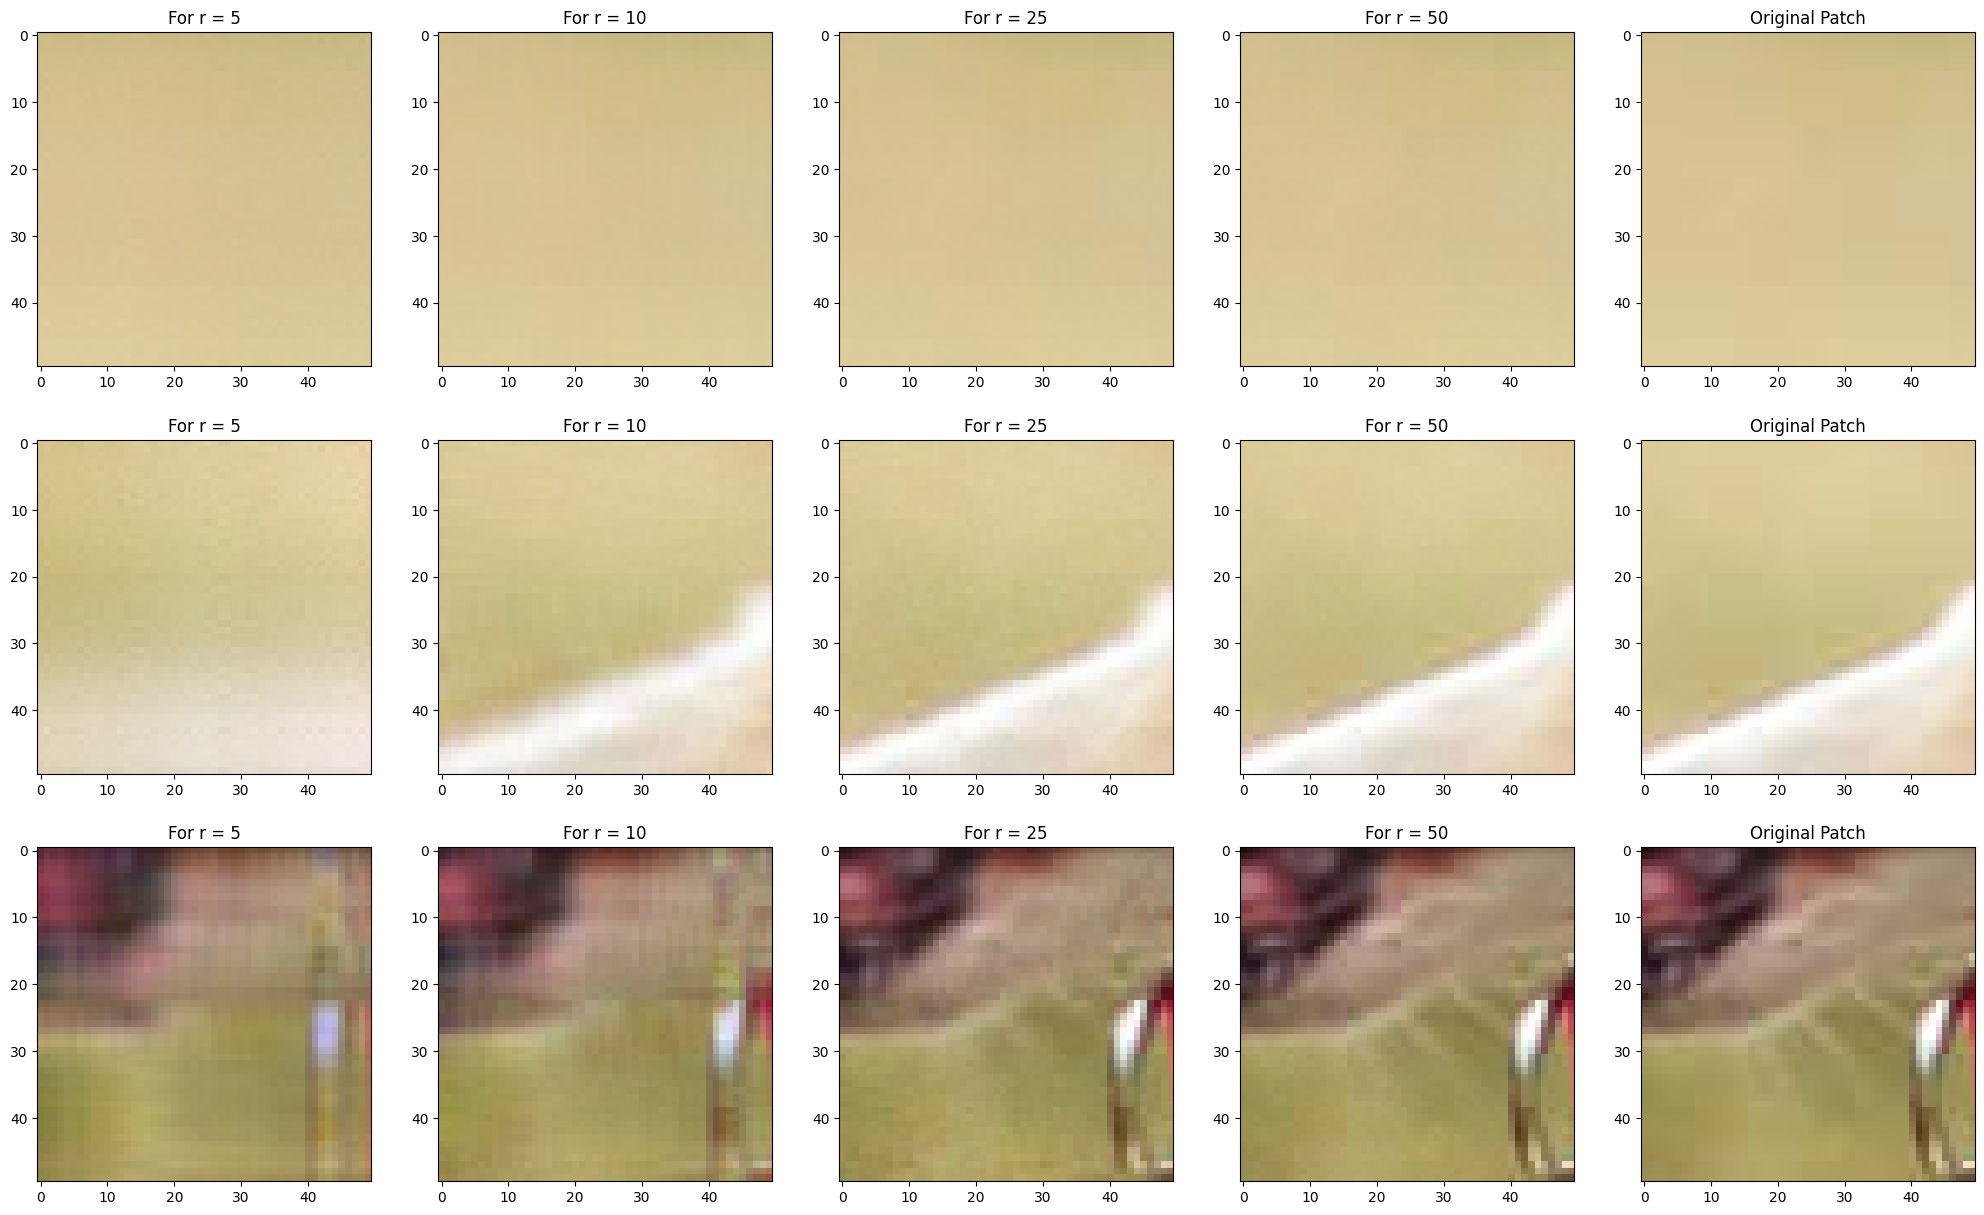

In [19]:
plt.figure(figsize=(25,15))
for i in range(3):
  plt.subplot(3,5,i*5+1)
  plt.imshow(pred_patchs[i*4].permute(1,2,0)/255)
  plt.title("For r = 5")

  plt.subplot(3,5,i*5+2)
  plt.imshow(pred_patchs[i*4+1].permute(1,2,0)/255)
  plt.title("For r = 10")

  plt.subplot(3,5,i*5+3)
  plt.imshow(pred_patchs[i*4+2].permute(1,2,0)/255)
  plt.title("For r = 25")

  plt.subplot(3,5,i*5+4)
  plt.imshow(pred_patchs[i*4+3].permute(1,2,0)/255)
  plt.title("For r = 50")

  plt.subplot(3,5,i*5+5)
  plt.imshow(patches[i].permute(1,2,0)/255)
  plt.title("Original Patch")


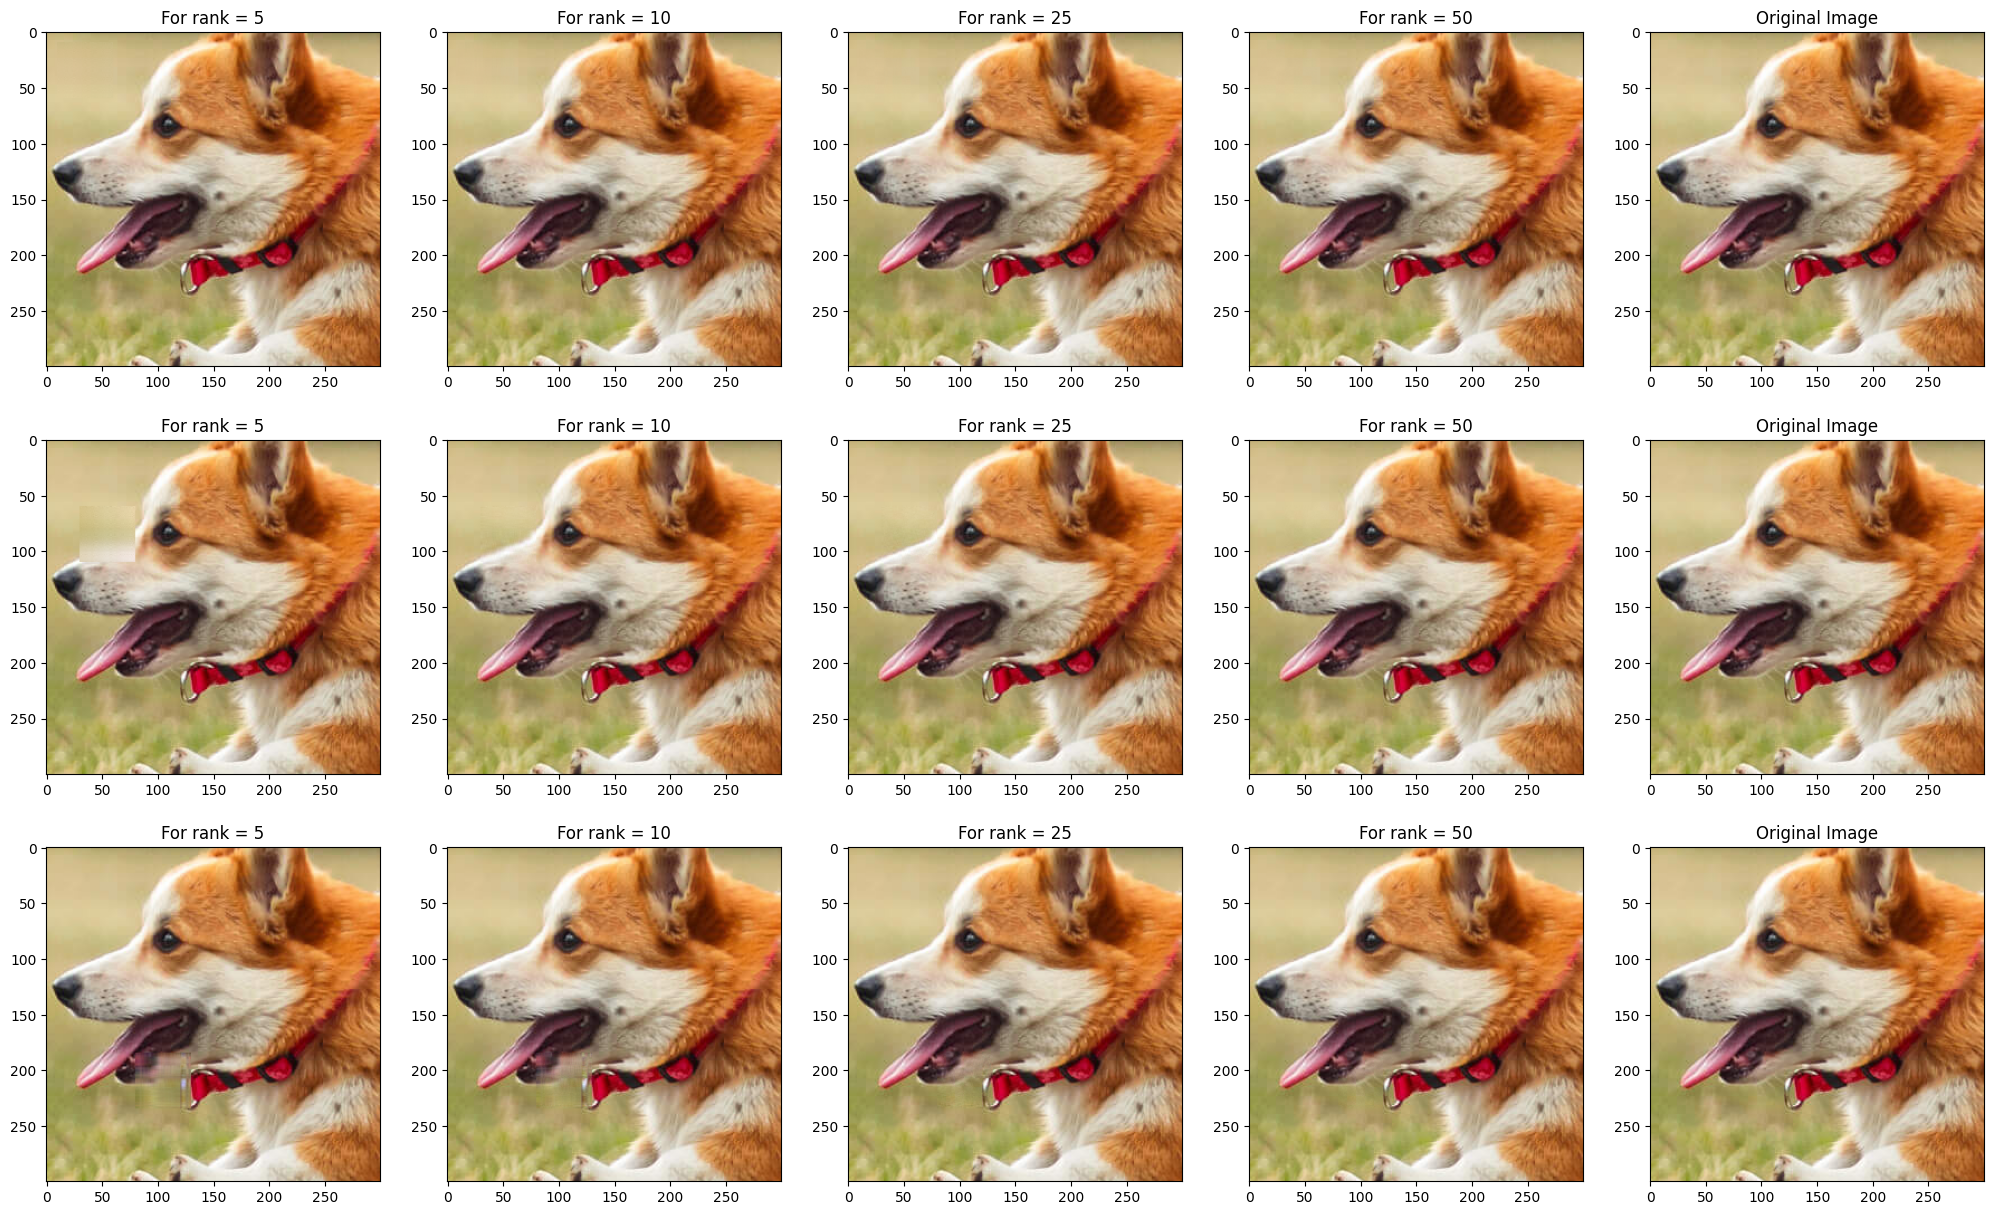

In [20]:

plt.figure(figsize=(25,15))
for i in range(3):
  imgcl = imgs[i].clone()
  imgcl[:,patch_locsx[i]:patch_locsx[i]+patch_size, patch_locsy[i]:patch_locsy[i]+patch_size] = pred_patchs[4*i]
  plt.subplot(3,5,i*5+1)
  plt.imshow(imgcl.permute(1,2,0)/255)
  plt.title("For rank = 5")

  imgcl[:,patch_locsx[i]:patch_locsx[i]+patch_size, patch_locsy[i]:patch_locsy[i]+patch_size] = pred_patchs[4*i+1]
  plt.subplot(3,5,i*5+2)
  plt.imshow(imgcl.permute(1,2,0)/255)
  plt.title("For rank = 10")

  imgcl[:,patch_locsx[i]:patch_locsx[i]+patch_size, patch_locsy[i]:patch_locsy[i]+patch_size] = pred_patchs[4*i+2]
  plt.subplot(3,5,i*5+3)
  plt.imshow(imgcl.permute(1,2,0)/255)
  plt.title("For rank = 25")

  imgcl[:,patch_locsx[i]:patch_locsx[i]+patch_size, patch_locsy[i]:patch_locsy[i]+patch_size] = pred_patchs[4*i+3]
  plt.subplot(3,5,i*5+4)
  plt.imshow(imgcl.permute(1,2,0)/255)
  plt.title("For rank = 50")

  plt.subplot(3,5,i*5+5)
  plt.imshow(crop.permute(1,2,0)/255)
  plt.title("Original Image")

1.676405848302664
0.83711933382768
0.5162226046628582
0.4074888398418398


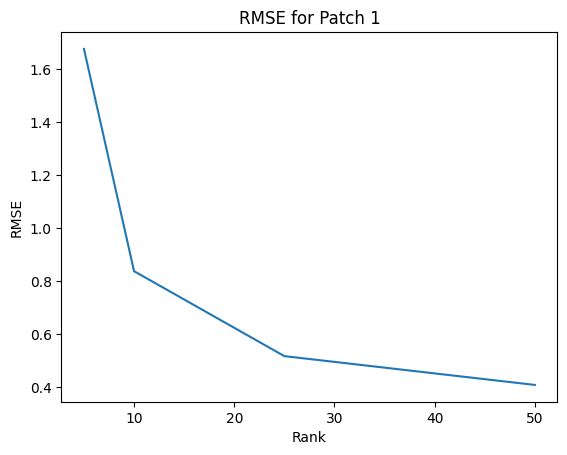

18.77533139277943
4.956840159651623
2.3282403630820476
0.740690353392561


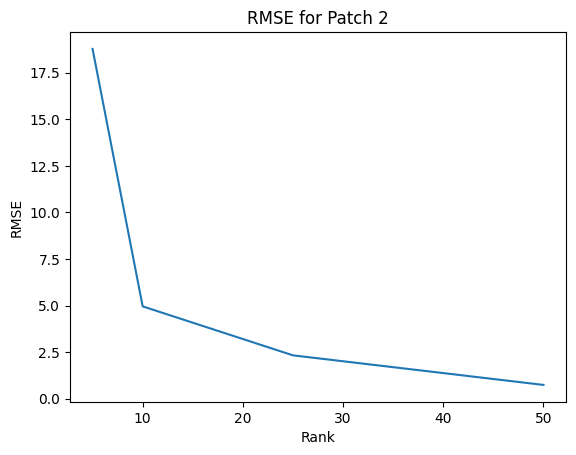

15.935357718562564
10.892561150882754
4.579431920206253
1.4572077982634917


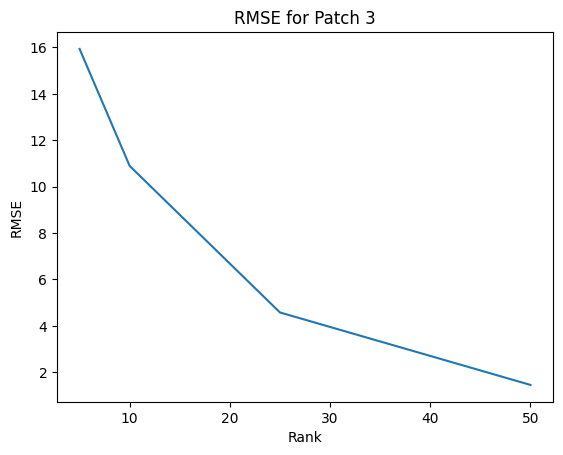

In [21]:
for i in range(3):
  # psnri = []
  rmsei = []
  for j in range(4):
    #psnri.append(peak_signal_noise_ratio(pred_patchs[4*i+j].permute(1,2,0).numpy(), patches[i].permute(1,2,0).numpy()))
    rmsei.append(np.sqrt(mean_squared_error(pred_patchs[4*i+j].permute(1,2,0).numpy(), patches[i].permute(1,2,0).numpy())))
    print(rmsei[j])

  plt.plot(r, rmsei)
  plt.title(f"RMSE for Patch {i+1}")
  plt.xlabel("Rank")
  plt.ylabel("RMSE")
  plt.show()
  #print("PSNR =", psnr,"\n")